In [1]:
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
    :param history: Training history of model
    :return:
    """
    
    # create accuracy subplot
    plt.figure()
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history['val_accuracy'], label="validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    #plt.title("Accuracy evaluation")
    plt.show()
    # create loss subplot
    plt.figure()
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history['val_loss'], label="validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    #plt.title("Loss evaluation")
    plt.show()
    
def load_data(data_path):
    """Loads training dataset from json file.
    :param data_path (str): Path to json file containing data
    :return X (ndarray): Inputs
    :return y (ndarray): Targets
    """
    with open(data_path, "r") as fp:
        data = json.load(fp)
        
    X = np.array(data["MFCCs"])
    y = np.array(data["labels"])
    print("Training sets loaded!")
    return X, y


def prepare_dataset(data_path, test_size=0.2, validation_size=0.2):
    """Creates train, validation and test sets.
    :param data_path (str): Path to json file containing data
    :param test_size (flaot): Percentage of dataset used for testing
    :param validation_size (float): Percentage of train set used for cross-validation
    :return X_train (ndarray): Inputs for the train set
    :return y_train (ndarray): Targets for the train set
    :return X_validation (ndarray): Inputs9 for the validation set
    :return y_validation (ndarray): Targets for the validation set
    :return X_test (ndarray): Inputs for the test set
    :return X_test (ndarray): Targets for the test set
    """
    # load dataset
    X, y = load_data(data_path)
    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    # add an axis to nd array
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    return X_train, y_train, X_validation, y_validation, X_test, y_test


def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    """Build neural network using keras.
    :param input_shape (tuple): Shape of array representing a sample train. E.g.: (44, 13, 1)
    :param loss (str): Loss function to use
    :param learning_rate (float):
    :return model: TensorFlow model
    """
    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()
    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape,
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))
    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))
    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))
    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    tf.keras.layers.Dropout(0.3)
    # softmax output layer
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)
    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])
    # print model parameters on console
    model.summary()
    return model


def train_model(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    """Trains model
    :param epochs (int): Num training epochs
    :param batch_size (int): Samples per batch
    :param patience (int): Num epochs to wait before early stop, if there isn't an improvement on accuracy
    :param X_train (ndarray): Inputs for the train set
    :param y_train (ndarray): Targets for the train set
    :param X_validation (ndarray): Inputs for the validation set
    :param y_validation (ndarray): Targets for the validation set
    :return history: Training history
    """
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)
    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history



In [3]:
DATA_PATH = "miData3p.json"
SAVED_MODEL_PATH = "model_final.h5"
EPOCHS = 10
BATCH_SIZE = 32
PATIENCE = 5
LEARNING_RATE = 0.001#0.0001

In [4]:
# generate train, validation and test sets
X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)

Training sets loaded!


In [5]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape, learning_rate=LEARNING_RATE)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 42, 11, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 42, 11, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 6, 64)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 4, 32)         18464     
                                                                 
 batch_normalization_1 (Batc  (None, 19, 4, 32)        128       
 hNormalization)                                                 
                                                        

In [6]:
# train network
#history = train_model(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

In [7]:
# plot accuracy/loss for training/validation set as a function of the epochs
#plot_history(history)

In [8]:
#Cargar modelo
model.load_weights('Model_final.h5')

In [9]:
# evaluate network on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

66/66 [==============================] - 4s 8ms/step - loss: 0.1468 - accuracy: 0.9691

Test loss: 0.14675837755203247, test accuracy: 96.90917730331421


In [10]:
# save model
#model.save(SAVED_MODEL_PATH)

In [11]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, ConfusionMatrixDisplay, recall_score, f1_score, precision_score

In [12]:
print(len(X_test))
preds=[]
for num in range(1,2103+1):
    y_pred=model.predict(X_test[num-1:num]) 
    predicted_index = np.argmax(y_pred)
    preds.append(predicted_index)

2103


(2103,) (2103,)
[[1384   49]
 [   9  661]]
[[1403    5]
 [  46  649]]
[[1354   11]
 [  10  728]]
[0.9866, 0.9338, 0.9864] 
 [0.9658, 0.9964, 0.9919] xd 

[0.9724, 0.9757, 0.99] 
 [0, 0, 0] 
 [0.9866, 0.9338, 0.9864] 
 [0.931, 0.9924, 0.9851] 
 [0.958, 0.9622, 0.9858]


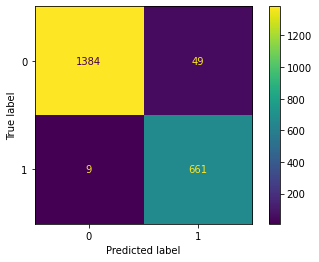

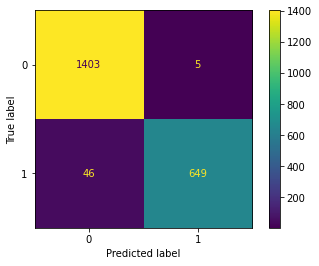

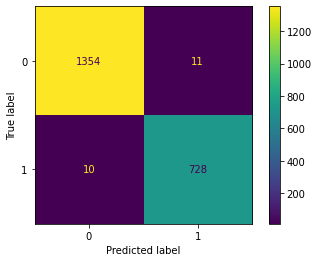

In [18]:
y_true=y_test.tolist()
y_hat=preds 
M=multilabel_confusion_matrix(y_true,y_hat) # Evaluación con matrix de VP FP VN FN de las 4 variables
print(np.shape(y_hat),np.shape(y_true))

sen=[]
esp=[]
acc=[]
loss=[]
pre=[]
rc=[]
f1=[]
    
for clase in range(0,3):

    k=M[clase]
    print(k)
    tn=k[0,0]
    fn=k[1,0]
    tp=k[1,1]
    fp=k[0,1]
    trp=tp/(tp+fn)#sensivity o true positive rate
    frp=fp/(fp+tn)#1-especificity o false positive rate
    accu=(tp+tn)/(tp+tn+fp+fn)
    lo=0
    recall=tp/(tp+fp)
    presicion=tp/(tp+fn)
    ff=(2*tp)/(2*tp+fp+fn)
    recall=tp/(tp+fp)
    
    sen.append(round(trp,4))
    esp.append(round(1-frp,4))
    acc.append(round(accu,4))
    loss.append(round(lo,4))
    f1.append(round(ff,4))
    rc.append(round(recall,4))
    pre.append(round(presicion,4))
    
    M_polo=ConfusionMatrixDisplay(M[clase:clase+1][0])
    M_polo.plot()
    
print(sen,'\n', esp,'xd \n')
print(acc,'\n', loss,'\n',pre,'\n',rc,'\n',f1)


In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

66/66 [==============================] - 0s 7ms/step - loss: 0.1468 - accuracy: 0.9691

Test loss: 0.14675837755203247, test accuracy: 96.90917730331421


In [15]:
precision_score(y_true, y_hat, average='macro')

0.9694852252839398

In [16]:
recall_score(y_true, y_hat, average='macro')

0.9689433261060124

In [17]:
f1_score(y_true, y_hat, average='macro')

0.968649074317765